In [1]:
from keras.layers import Activation, Conv2D, BatchNormalization, Dense, AveragePooling2D, Concatenate
from keras.layers import Dropout, Flatten, Input, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras import Model 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
IMSIZE=128

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/mnt/data/CatDog/validation',
    target_size=(IMSIZE, IMSIZE),
    batch_size=32,
    class_mode='categorical')

train_generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.5,
                                    rotation_range=30,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True).flow_from_directory(
    '/mnt/data/CatDog/train',
    target_size=(IMSIZE, IMSIZE),
    batch_size=32,
    class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 15000 images belonging to 2 classes.


<Figure size 432x288 with 0 Axes>

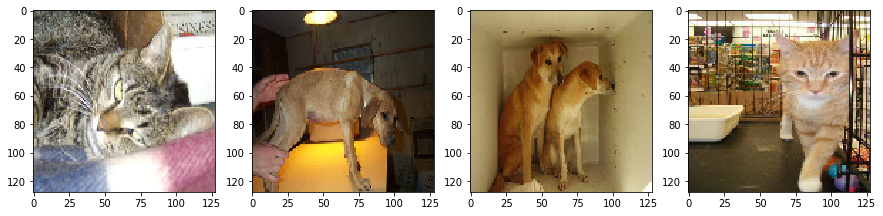

In [3]:
from matplotlib import pyplot as plt
plt.figure()
fig,ax = plt.subplots(1,4)
fig.set_figheight(6)
fig.set_figwidth(15)
ax = ax.flatten()
X,Y = next(validation_generator)
for i in range(4):ax[i].imshow(X[i,:,:,:])

In [4]:
n_blocks = 4
nb_layers = 3
growth_rate = 32
input_layer = Input([IMSIZE,IMSIZE,3])
x = input_layer
x = BatchNormalization()(x)
x = Conv2D(growth_rate*2 , (3,3), padding='same', activation='relu')(x)

for j in range(n_blocks):
    # 1.Dense Block
    feature_list=[x]
    for i in range(nb_layers):
        x = BatchNormalization()(x)
#         x = Activation('relu')(x)
        x = Conv2D(growth_rate,(3,3), padding='same', activation='relu')(x)
#         x = Conv2D(4000,(1,1),padding='same',activation='relu')(x)
        feature_list.append(x)
        if i < (nb_layers-1):
            x = Concatenate()(feature_list)
    # 2.Transition Block
    if j < (n_blocks - 1):
        x = BatchNormalization()(x)
#         x = Activation('relu')(x)
        x = Conv2D(growth_rate,(1,1),padding='same', activation='relu')(x)
        x = AveragePooling2D((2,2),strides=(2,2))(x)

#设置最后一个Dense Block
feature_list = [x]
for i in range(nb_layers):
    x = Conv2D(growth_rate,(3,3),padding='same',activation='relu')(x)
    feature_list.append(x)
    if i<(nb_layers-1):
        x = Concatenate()(feature_list)

x = GlobalAveragePooling2D()(x)
x = Dense(2,activation='softmax')(x)
output_layer = x
model = Model(input_layer,output_layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
469/469 [==============================] - 342s 729ms/step - loss: 0.6548 - accuracy: 0.6169 - val_loss: 0.5864 - val_accuracy: 0.6412
Epoch 2/10
469/469 [==============================] - 329s 701ms/step - loss: 0.6178 - accuracy: 0.6617 - val_loss: 0.6432 - val_accuracy: 0.6101
Epoch 3/10
469/469 [==============================] - 311s 664ms/step - loss: 0.5923 - accuracy: 0.6887 - val_loss: 0.7631 - val_accuracy: 0.6817
Epoch 4/10
469/469 [==============================] - 389s 830ms/step - loss: 0.5753 - accuracy: 0.7035 - val_loss: 0.4658 - val_accuracy: 0.7283
Epoch 5/10
469/469 [==============================] - 368s 784ms/step - loss: 0.5450 - accuracy: 0.7279 - val_loss: 0.6224 - val_accuracy: 0.7468
Epoch 6/10
469/469 [==============================] - 324s 692ms/step - loss: 0.5141 - accuracy: 0.7485 - val_loss: 0.3364 - val_accuracy: 0.7785
Epoch 7/10
469/469 [==============================] - 385s 821ms/step - loss: 0.4828 - accuracy: 0.7665 - val_loss: 0.4687 -

In [6]:
n_blocks = 4
nb_layers = 6
growth_rate = 24
input_layer = Input([IMSIZE,IMSIZE,3])
x = input_layer
x = BatchNormalization()(x)
x = Conv2D(growth_rate*2 , (3,3), padding='same', activation='relu')(x)

for j in range(n_blocks):
    # 1.Dense Block
    feature_list=[x]
    for i in range(nb_layers):
        #  bottleneck 
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(4*growth_rate, (1,1), padding='same')(x)
        
        # 3*3 conv
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate,(3,3), padding='same')(x)
        feature_list.append(x)
        if i < (nb_layers-1):
            x = Concatenate()(feature_list)
    # 2.Transition Block
    if j  < n_blocks - 1:
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(growth_rate, (1,1), padding='same')(x)
        x = AveragePooling2D((2,2), strides=(2,2))(x)


x = GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)
output_layer = x
model = Model(input_layer, output_layer, name='DenseNet-BC')
model.summary()

Model: "DenseNet-BC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 128, 128, 3)  12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 48) 1344        batch_normalization_17[0][0]     
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 48) 192         conv2d_20[0][0]                  
________________________________________________________________________________________

In [13]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.fit(train_generator,epochs=15,validation_data=validation_generator)

Epoch 1/15
469/469 [==============================] - 153s 325ms/step - loss: 0.6711 - accuracy: 0.5949 - val_loss: 0.7386 - val_accuracy: 0.5770
Epoch 2/15
469/469 [==============================] - 151s 322ms/step - loss: 0.6485 - accuracy: 0.6206 - val_loss: 0.6944 - val_accuracy: 0.5688
Epoch 3/15
469/469 [==============================] - 151s 321ms/step - loss: 0.6368 - accuracy: 0.6343 - val_loss: 0.6613 - val_accuracy: 0.5836
Epoch 4/15
469/469 [==============================] - 151s 322ms/step - loss: 0.6251 - accuracy: 0.6516 - val_loss: 0.6150 - val_accuracy: 0.6591
Epoch 5/15
469/469 [==============================] - 152s 324ms/step - loss: 0.5959 - accuracy: 0.6848 - val_loss: 0.6047 - val_accuracy: 0.6758
Epoch 6/15
469/469 [==============================] - 150s 321ms/step - loss: 0.5795 - accuracy: 0.6967 - val_loss: 0.5990 - val_accuracy: 0.6856
Epoch 7/15
469/469 [==============================] - 151s 322ms/step - loss: 0.5602 - accuracy: 0.7153 - val_loss: 1.1615 -

In [14]:
model.fit(train_generator,epochs=5,validation_data=validation_generator)

Epoch 1/5
469/469 [==============================] - 151s 321ms/step - loss: 0.4365 - accuracy: 0.8011 - val_loss: 0.4942 - val_accuracy: 0.7821
Epoch 2/5
469/469 [==============================] - 150s 321ms/step - loss: 0.4134 - accuracy: 0.8117 - val_loss: 0.4005 - val_accuracy: 0.8222
Epoch 3/5
469/469 [==============================] - 150s 319ms/step - loss: 0.4018 - accuracy: 0.8174 - val_loss: 0.3937 - val_accuracy: 0.8264
Epoch 4/5
469/469 [==============================] - 150s 321ms/step - loss: 0.3842 - accuracy: 0.8304 - val_loss: 0.3922 - val_accuracy: 0.8322
Epoch 5/5
469/469 [==============================] - 149s 318ms/step - loss: 0.3708 - accuracy: 0.8351 - val_loss: 0.4587 - val_accuracy: 0.7894
